In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [2]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super(UNet, self).__init__()

        # Down sampling
        self.conv1 = double_conv(in_channels, 64)
        self.conv2 = double_conv(64, 128)
        self.conv3 = double_conv(128, 256)
        self.conv4 = double_conv(256, 512)

        # Up sampling
        self.up_conv1 = up_conv(512, 256)
        self.conv5 = double_conv(512, 256)
        self.up_conv2 = up_conv(256, 128)
        self.conv6 = double_conv(256, 128)
        self.up_conv3 = up_conv(128, 64)
        self.conv7 = double_conv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Down sampling
        x1 = self.conv1(x)
        x2 = self.conv2(F.max_pool2d(x1, 2))
        x3 = self.conv3(F.max_pool2d(x2, 2))
        x4 = self.conv4(F.max_pool2d(x3, 2))

        # Up sampling
        x = self.up_conv1(x4)
        x = torch.cat([x3, x], dim=1)
        x = self.conv5(x)
        x = self.up_conv2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv6(x)
        x = self.up_conv3(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv7(x)

        x = self.final_conv(x)
        return x

In [4]:
"""
def custom_loss(sigma_sq, v, v_t):
    eps = 1e-8
    sigma_sq = sigma_sq + eps
    loss = 0.5 * torch.log(sigma_sq) + (v_t - v) ** 2 / (2 * sigma_sq)
    return torch.mean(loss)
"""

'\ndef custom_loss(sigma_sq, v, v_t):\n    eps = 1e-8\n    sigma_sq = sigma_sq + eps\n    loss = 0.5 * torch.log(sigma_sq) + (v_t - v) ** 2 / (2 * sigma_sq)\n    return torch.mean(loss)\n'

In [5]:
def custom_loss(sigma, v, v_t):
    eps = 1e-10
    sigma2 = sigma ** 2 + eps
    # print(f"sigam2.shape: {sigma2.shape}, v.shape: {v.shape}, v_t.shape: {v_t.shape}")
    loss = torch.log(sigma2) + (v_t - v) ** 2 / sigma2
    return loss.mean()

In [6]:
class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.data_files = glob.glob(os.path.join(self.data_path, 'JHTDB*.npy'))
        # self.data_files = sorted(self.data_path)
        randomidx = np.random.permutation(len(self.data_files))
        self.data_files = [self.data_files[i] for i in randomidx]
        print(self.data_files)
        
    def __len__(self):
        return len(self.data_files)

    """
    `__getitem__` 方法会在每次加载一个数据时被调用，
    它会从指定路径中读取 `.npy` 文件，并将其转换为一个 PyTorch 张量。
    然后，使用 PyTorch 提供的 `DataLoader` 类，将数据划分为批次进行训练。
    """
    def __getitem__(self, index):
        # Load data from file
        # data = np.load(os.path.join(self.data_path, self.data_files[index]))
        data = np.load(self.data_files[index])
        # data = data[0:4]
        # Convert to tensor
        data = torch.from_numpy(data).float()
        return data

In [7]:
def load_data(data_path, batch_size):
    # Create data loader
    dataset = MyDataset(data_path)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_loader

In [8]:
def remap(inputs, device):
    inputs = inputs.cpu().numpy()
    N = inputs.shape[0]
    inputs_split_list = np.split(inputs, N, axis=0)
    inputs_split_list = [np.squeeze(i, axis=0) for i in inputs_split_list]
    # print(inputs_split_list[0].shape)
    for i in range(N):
        img0 = inputs_split_list[i][0]
        img1 = inputs_split_list[i][1]
        u = inputs_split_list[i][2]
        v = inputs_split_list[i][3]

        x, y = np.meshgrid(np.arange(img1.shape[1]), np.arange(img1.shape[0]))
        x = np.float32(x)
        y = np.float32(y)
        img0 = cv.remap(img0, x+u, y+v, interpolation = 4)
        
    inputs_new = np.stack(inputs_split_list, axis = 0)
    inputs_new = torch.from_numpy(inputs_new)

    return inputs_new.to(device)
        

In [9]:
def train(model, optimizer, data_loader, num_epochs, device):
    model.to(device)

    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_metric = 0.0
        num_batches = 0

        for batch in data_loader:
            batch = batch.to(device)

            inputs = batch[:, :4, :, :]
            remap(inputs, device)
            v = batch[:, 2:4, :, :]
            v_t = batch[:, 4:6, :, :]
            inputs = remap(inputs, device)
            # 将梯度清零
            optimizer.zero_grad()
            # 前向传递
            sigma = model(inputs)
            # 计算损失和评估指标
            loss = custom_loss(sigma, v, v_t)
            metric = -loss.item()
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            # 更新损失和评估指标
            epoch_loss += loss.item()
            epoch_metric += metric
            num_batches += 1

        # 计算平均损失和评估指标
        avg_loss = epoch_loss / num_batches
        avg_metric = epoch_metric / num_batches
        losses.append(avg_loss)
        # 打印训练进度
        print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Metric={avg_metric:.4f}")

        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.title('Training Loss')
        plt.savefig('loss.png')    
        torch.save(model.state_dict(), 'model.pt')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.title('Training Loss')
    plt.savefig('loss.png')    
    torch.save(model.state_dict(), 'model.pt')

In [10]:
"""
------------------------------训练部分------------------------------
"""
# 加载数据
data_path = '/home/panding/code/UR/piv-data/ur'
batch_size = 10

my_data_loader = load_data(data_path, batch_size)

# 初始化模型、优化器和设备
net = UNet(in_channels=4, out_channels=1)
Adam_optimizer = optim.Adam(net.parameters(), lr=0.01)
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练循环
my_num_epochs = 100

['/home/panding/code/UR/piv-data/ur/JHTDB_channel_hd_00431.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_channel_01558.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_isotropic1024_hd_01794.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_isotropic1024_hd_01294.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_channel_hd_00383.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_mhd1024_hd_00687.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_mhd1024_hd_00665.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_mhd1024_hd_00707.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_channel_01229.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_mhd1024_hd_00502.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_channel_01637.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_isotropic1024_hd_01662.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_channel_01409.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_channel_hd_00468.npy', '/home/panding/code/UR/piv-data/ur/JHTDB_isotropic1024_hd_01745.npy', '/home/panding/code/UR/piv-

/home/panding/miniconda3/envs/ur/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/100: Loss=3138.1695, Metric=-3138.1695
Epoch 2/100: Loss=1855.4948, Metric=-1855.4948
Epoch 3/100: Loss=1977.8405, Metric=-1977.8405
Epoch 4/100: Loss=1009.4269, Metric=-1009.4269
Epoch 5/100: Loss=851.4211, Metric=-851.4211
Epoch 6/100: Loss=1466.5137, Metric=-1466.5137
Epoch 7/100: Loss=484.7170, Metric=-484.7170
Epoch 8/100: Loss=3.1453, Metric=-3.1453
Epoch 9/100: Loss=3.1274, Metric=-3.1274
Epoch 10/100: Loss=3.1316, Metric=-3.1316
Epoch 11/100: Loss=3.1323, Metric=-3.1323
Epoch 12/100: Loss=3.1424, Metric=-3.1424
Epoch 13/100: Loss=3.1382, Metric=-3.1382
Epoch 14/100: Loss=3.1388, Metric=-3.1388
Epoch 15/100: Loss=3.1438, Metric=-3.1438
Epoch 16/100: Loss=3.1439, Metric=-3.1439
Epoch 17/100: Loss=3.1394, Metric=-3.1394
Epoch 18/100: Loss=3.1550, Metric=-3.1550
Epoch 19/100: Loss=3.1377, Metric=-3.1377
Epoch 20/100: Loss=3.1475, Metric=-3.1475
Epoch 21/100: Loss=3.1431, Metric=-3.1431
Epoch 22/100: Loss=3.1407, Metric=-3.1407
Epoch 23/100: Loss=3.1278, Metric=-3.1278


KeyboardInterrupt: 

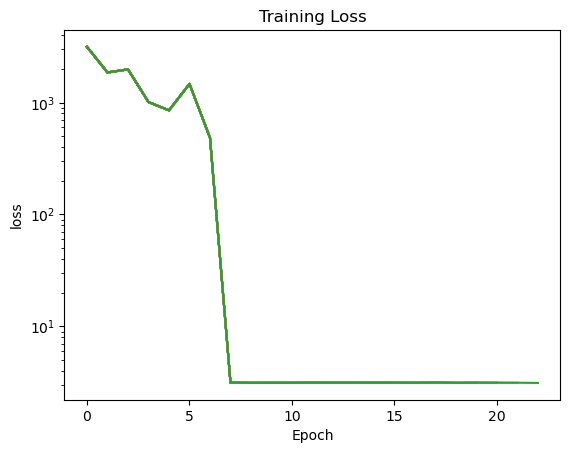

In [11]:
train(model=net, optimizer=Adam_optimizer, data_loader=my_data_loader, num_epochs=my_num_epochs, device=my_device)